In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

print("Shape of training dataset is {}".format(train.shape))
print("Shape of testing dataset is {}".format(test.shape))

Shape of training dataset is (116058, 29)
Shape of testing dataset is (35866, 28)


In [4]:
train["Type"]=1
test["Type"]=0

In [5]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m5,m6,m7,m8,m9,m10,m11,m12,m13,Type
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,1,0,0,0,0,0,1,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,1,0,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,1,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,1,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,4,5,6,7,8,9,10,11,1,1


In [6]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,Type
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
loan=pd.concat([train,test], ignore_index=True, sort=True)
loan.head()

,Type,borrower_credit_score,co-borrower_credit_score,debt_to_income_ratio,financial_institution,first_payment_date,insurance_percent,insurance_type,interest_rate,loan_id,...,m4,m5,m6,m7,m8,m9,number_of_borrowers,origination_date,source,unpaid_principal_bal
0,1,694.0,0.0,22.0,"Turner, Baldwin and Rhodes",05/2012,30.0,0.0,4.250,268055008619,...,0,0,0,1,0,0,1.0,2012-03-01,Z,214000
1,1,697.0,0.0,44.0,"Swanson, Newton and Miller",03/2012,0.0,0.0,4.875,672831657627,...,0,0,0,0,0,0,1.0,2012-01-01,Y,144000
2,1,780.0,0.0,33.0,Thornton-Davis,03/2012,0.0,0.0,3.250,742515242108,...,0,0,0,0,0,0,1.0,2012-01-01,Z,366000
3,1,633.0,638.0,44.0,OTHER,04/2012,0.0,0.0,4.750,601385667462,...,0,0,0,0,0,1,2.0,2012-02-01,X,135000
4,1,681.0,0.0,43.0,OTHER,04/2012,0.0,0.0,4.750,273870029961,...,3,4,5,6,7,8,1.0,2012-02-01,X,124000


In [8]:
loan.columns

Index(['Type', 'borrower_credit_score', 'co-borrower_credit_score',
       'debt_to_income_ratio', 'financial_institution', 'first_payment_date',
       'insurance_percent', 'insurance_type', 'interest_rate', 'loan_id',
       'loan_purpose', 'loan_term', 'loan_to_value', 'm1', 'm10', 'm11', 'm12',
       'm13', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       'number_of_borrowers', 'origination_date', 'source',
       'unpaid_principal_bal'],
      dtype='object')

In [9]:
loan.origination_date.value_counts()

2012-02-01    52334
2012-01-01    49093
01/02/12      16423
01/01/12      15051
2012-03-01    14631
01/03/12       4392
Name: origination_date, dtype: int64

In [10]:
def date_format(x):
    if str(x).find("/") != -1 :
        x=dt.strptime(x, '%d/%m/%y')
        return x
    else:
        x=dt.strptime(x, '%Y-%m-%d')
        return x

loan.origination_date=loan.origination_date.apply(date_format)

In [11]:
loan.origination_date.value_counts()

2012-02-01    68757
2012-01-01    64144
2012-03-01    19023
Name: origination_date, dtype: int64

In [12]:
loan.first_payment_date.value_counts()

04/2012    52840
03/2012    47680
Apr-12     16551
05/2012    15014
Mar-12     14661
May-12      4510
02/2012      524
Feb-12       144
Name: first_payment_date, dtype: int64

In [13]:
def date_format1(x):
    if str(x).find("/") != -1 :
        x=dt.strptime(x, '%m/%Y')
        return x
    else:
        x=dt.strptime(x, '%b-%y')
        return x

loan.first_payment_date=loan.first_payment_date.apply(date_format1)

In [14]:
loan.first_payment_date.value_counts()

2012-04-01    69391
2012-03-01    62341
2012-05-01    19524
2012-02-01      668
Name: first_payment_date, dtype: int64

#### Feature Engineering

In [15]:
loan['all_months_deliquency']=loan[['m1', 'm10', 'm11', 'm12','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9']].sum(axis=1)
loan=loan.drop(columns=['m1', 'm10', 'm11', 'm12','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9'])

In [16]:
loan['overall_borrower_cred_score']=loan[['borrower_credit_score','co-borrower_credit_score']].sum(axis=1)
loan=loan.drop(columns=['borrower_credit_score','co-borrower_credit_score'])

In [17]:
loan['DelayInFirstInstall']=(loan.first_payment_date - loan.origination_date).dt.days
loan=loan.drop(columns=['first_payment_date','origination_date'])

In [18]:
loan['DelayInFirstInstall'].value_counts()

60    125707
61     17495
91      2816
31      2196
90      2029
29      1681
Name: DelayInFirstInstall, dtype: int64

In [19]:
# Converting loan term into years

loan['loan_term']=loan['loan_term']//12

In [20]:
loan['Interest']=(loan.unpaid_principal_bal) * (loan.interest_rate)
loan=loan.drop(columns=['unpaid_principal_bal','interest_rate'])

In [21]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151924 entries, 0 to 151923
Data columns (total 16 columns):
Type                           151924 non-null int64
debt_to_income_ratio           151924 non-null float64
financial_institution          151924 non-null object
insurance_percent              151924 non-null float64
insurance_type                 151924 non-null float64
loan_id                        151924 non-null int64
loan_purpose                   151924 non-null object
loan_term                      151924 non-null int64
loan_to_value                  151924 non-null int64
m13                            116058 non-null float64
number_of_borrowers            151924 non-null float64
source                         151924 non-null object
all_months_deliquency          151924 non-null int64
overall_borrower_cred_score    151924 non-null float64
DelayInFirstInstall            151924 non-null int64
Interest                       151924 non-null float64
dtypes: float64(7), int6

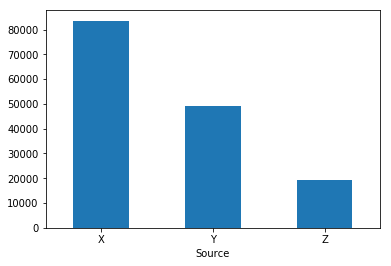

In [22]:
#data=loan.query('Type == 1')

loan.source.value_counts().plot(kind='bar')
plt.xlabel("Source")
plt.xticks(rotation=360)
plt.show()

In [23]:
loan.head(10)

,Type,debt_to_income_ratio,financial_institution,insurance_percent,insurance_type,loan_id,loan_purpose,loan_term,loan_to_value,m13,number_of_borrowers,source,all_months_deliquency,overall_borrower_cred_score,DelayInFirstInstall,Interest
0,1,22.0,"Turner, Baldwin and Rhodes",30.0,0.0,268055008619,C86,30,95,1.0,1.0,Z,1,694.0,61,909500.0
1,1,44.0,"Swanson, Newton and Miller",0.0,0.0,672831657627,B12,30,72,1.0,1.0,Y,1,697.0,60,702000.0
2,1,33.0,Thornton-Davis,0.0,0.0,742515242108,B12,15,49,1.0,1.0,Z,0,780.0,60,1189500.0
3,1,44.0,OTHER,0.0,0.0,601385667462,B12,30,46,1.0,2.0,X,4,1271.0,60,641250.0
4,1,43.0,OTHER,0.0,0.0,273870029961,C86,30,80,1.0,1.0,X,66,681.0,60,589000.0
5,1,46.0,Browning-Hart,0.0,0.0,769060024464,C86,30,80,1.0,1.0,Y,1,675.0,60,656250.0
6,1,44.0,OTHER,30.0,0.0,148071614687,C86,30,95,1.0,1.0,X,0,723.0,60,236000.0
7,1,45.0,Browning-Hart,0.0,0.0,853383953266,A23,25,62,1.0,1.0,Y,1,652.0,60,1435500.0
8,1,35.0,Browning-Hart,0.0,0.0,423590072335,C86,30,76,1.0,1.0,X,6,808.0,61,2080000.0
9,1,41.0,OTHER,30.0,0.0,308990846816,A23,30,95,1.0,2.0,X,9,1402.0,60,856000.0


In [24]:
#### Using One hot encoding for Sources and loan_purpose columns

In [25]:
loan.source.value_counts()

X    83572
Y    49207
Z    19145
Name: source, dtype: int64

In [26]:
loan.loan_purpose.value_counts()

A23    76354
B12    38580
C86    36990
Name: loan_purpose, dtype: int64

In [27]:
loan=pd.get_dummies(columns=['loan_purpose','source'], data=loan, drop_first=True)

#### Using Label Encoding for financial_institution columns

In [28]:
loan.financial_institution.unique().shape

(19,)

In [29]:
le=LabelEncoder()
loan.financial_institution=le.fit_transform(loan.financial_institution)

In [30]:
loan.head(15)

,Type,debt_to_income_ratio,financial_institution,insurance_percent,insurance_type,loan_id,loan_term,loan_to_value,m13,number_of_borrowers,all_months_deliquency,overall_borrower_cred_score,DelayInFirstInstall,Interest,loan_purpose_B12,loan_purpose_C86,source_Y,source_Z
0,1,22.0,18,30.0,0.0,268055008619,30,95,1.0,1.0,1,694.0,61,909500.0,0,1,0,1
1,1,44.0,15,0.0,0.0,672831657627,30,72,1.0,1.0,1,697.0,60,702000.0,1,0,1,0
2,1,33.0,17,0.0,0.0,742515242108,15,49,1.0,1.0,0,780.0,60,1189500.0,1,0,0,1
3,1,44.0,8,0.0,0.0,601385667462,30,46,1.0,2.0,4,1271.0,60,641250.0,1,0,0,0
4,1,43.0,8,0.0,0.0,273870029961,30,80,1.0,1.0,66,681.0,60,589000.0,0,1,0,0
5,1,46.0,1,0.0,0.0,769060024464,30,80,1.0,1.0,1,675.0,60,656250.0,0,1,1,0
6,1,44.0,8,30.0,0.0,148071614687,30,95,1.0,1.0,0,723.0,60,236000.0,0,1,0,0
7,1,45.0,1,0.0,0.0,853383953266,25,62,1.0,1.0,1,652.0,60,1435500.0,0,0,1,0
8,1,35.0,1,0.0,0.0,423590072335,30,76,1.0,1.0,6,808.0,61,2080000.0,0,1,0,0
9,1,41.0,8,30.0,0.0,308990846816,30,95,1.0,2.0,9,1402.0,60,856000.0,0,0,0,0


In [31]:
data=loan
data.head()

,Type,debt_to_income_ratio,financial_institution,insurance_percent,insurance_type,loan_id,loan_term,loan_to_value,m13,number_of_borrowers,all_months_deliquency,overall_borrower_cred_score,DelayInFirstInstall,Interest,loan_purpose_B12,loan_purpose_C86,source_Y,source_Z
0,1,22.0,18,30.0,0.0,268055008619,30,95,1.0,1.0,1,694.0,61,909500.0,0,1,0,1
1,1,44.0,15,0.0,0.0,672831657627,30,72,1.0,1.0,1,697.0,60,702000.0,1,0,1,0
2,1,33.0,17,0.0,0.0,742515242108,15,49,1.0,1.0,0,780.0,60,1189500.0,1,0,0,1
3,1,44.0,8,0.0,0.0,601385667462,30,46,1.0,2.0,4,1271.0,60,641250.0,1,0,0,0
4,1,43.0,8,0.0,0.0,273870029961,30,80,1.0,1.0,66,681.0,60,589000.0,0,1,0,0


In [32]:
X=data.drop(columns='loan_id')

print(X.shape)

(151924, 17)


In [33]:
xtrain=X[X['Type'] == 1]

In [34]:
xtest=X[X['Type'] == 0]

In [35]:
ytrain=data[data['Type'] == 1].m13

In [37]:
xtrain=xtrain.drop(columns=['Type','m13'])
xtest=xtest.drop(columns=['Type','m13'])

In [38]:
xgb_model = xgb.XGBClassifier()

In [39]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.7], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [6],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [27]}

In [40]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=5, 
                   scoring='f1',
                   verbose=2, refit=True)

In [41]:
clf.fit(xtrain,ytrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.7], 'max_depth': [6], 'min_child_weight': [6], 'subsample': [0.8], 'colsample_bytree': [0.8], 'n_estimators': [1000], 'missing': [-999], 'seed': [27]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [42]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw F1 score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [43]:
ypred = clf.predict(xtest)

In [47]:
predictions=pd.DataFrame()
predictions['m13']=ypred
predictions['loan_id']=test.loan_id

In [48]:
predictions.head()

,m13,loan_id
0,0.0,1
1,0.0,2
2,0.0,3
3,0.0,4
4,0.0,5


In [49]:
predictions.to_csv("LoanDelinq_Predict_xgboost.csv", index=False)

rfc = RandomForestClassifier()
rfc_mod = rfc.fit(xtrain, ytrain)
ypred1 = rfc_mod.predict(xtest)